# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

딥러닝 논문에서는 다양한 방법들을 적용하며, 그 방법 적용 전후의 차이를 실험 결과로 보여준다. 이때 논문에는 어느 정도 구현 방법과 실험의 설정이 나와있어, 하드웨어 자원이 엄청 많이 필요하거나, 특정한 데이터셋이 필요한 경우를 제외하면 어느 정도 따라해볼 수 있다. 이번 시간에 모델을 구현하고, 모델에 각 기법을 적용의 유무에 따라 결과물을 확인해보자.

# 2-2. Ablation Study

- ["In the context of deep learning, what is an ablation study?"](https://www.quora.com/In-the-context-of-deep-learning-what-is-an-ablation-study)

지금 하는 프로젝트는 __애블레이션 연구(ablation study)__로 직역하면 제거 연구가 된다.

딥러닝 논문은 여러 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시한다. 이때 제한한 방법들의 유효함을 증명하기 위해 딥러닝 논문에서 해당 방법을 제거한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교한다.   
ablation 연구란 이처럼 아이디어를 제거하며 제안한 방법이 어떻게 성능이나 문제 해결에 효과를 주는지 확인할 수 있다.


![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-2_KU8V5aZ.max-800x600.png)
ResNet 논문에서 제기한 residual connection의 애블레이션 연구 자료이다. ImageNet 검증 데이터셋에 대한 Top-1 error rate를 지표로 사용해 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교했다. 이 비교를 통해 ResNet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 얻을 수 있음을 증명하고 있다.

# 2-3. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

__ResNet__이 공개된 시점으로 돌아갔다는 생각을해보자. 이 방법이 논문으로 유효하다 들었지만, 직접 실험을 하여 성능 평가와 다른 실험에 적용해보자. 논문과 동일한 데이터셋을 사용하면 좋겠지만, 컴퓨팅 자원이 부족하므로 CIFAR-10 데이터셋으로 평가해보자.

지금부터 CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인해보자.   
- [Deep residual learning for image recognition](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)
- [CIFAR-10 from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10)

### 1) CIFAR-10

CIFAR-10 데이터셋은 10개 카테고리에 총 6만장의 이미지가 있다. 가로, 세로 32pixel로 이루어져 있고, 물체의 종류를 분류해야한다.

In [ ]:
! pip list | grep tensorflow-datasets

tensorflow-datasets           4.0.1


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteESTO9T/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteESTO9T/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 `ds_train.shape` 방법으로 확인할 수 없다. 하지만 위의 방법으로 이미지의 shape, 전체 데이터의 개수, 라벨 클래스 개수 등 중요한 정보를 확인할 수 있다.

### 2) Input Normalization

__Data Normalization__은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것이다. 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 갖는데, 이를 255로 나누면 0~1.0 사이의 값을 갖게 된다.   
$x-x_{min}/x_{max}-x_{min}$   
(정규화하고자 하는 값 - 데이터 값중 최소값) / (데이터 값중 최대값 - 데이터 값중 최소값)

Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이는 것이다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/image_3GLaa5Y.max-800x600.png)   
그림을 보면 좌측이 정규화 하지 않은 경우의 cost function이고, 우측이 정규화한 cost function 일때, 정규화 한 경우에 local optimum에서 더 빨리 빠져나올 수 있음을 확인할 수 있다. scikit-learn에서 MinMaxScaler로 쉽게 사용할 수 있다.

이미지를 보통 말할때 가로 1920, 세로 1080 픽셀 이미지로 표현하는데, 이 때 이미지의 채널 값에 따라 픽셀의 색을 표현한다. RGB는 red, green, blue 세 가지 값을 조합해서 색을 표현한다. 그리고 이는 세 가지 채널값을 의미한다.   

모델에 넣어주기 전에 채널별 최댓값인 255을 0과 1사이로 __정규화(normalize)__를 적용하자.

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

MNIST 데이터셋 클래스는 0부터 9까지의 숫자로 총 10가지가 있다. CIFAR-10 데이터셋도 10개의 클래스를 가진다. 이들이 어떻게 구성되는지, 어떤 이미지가 있는지 확인해보자.

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

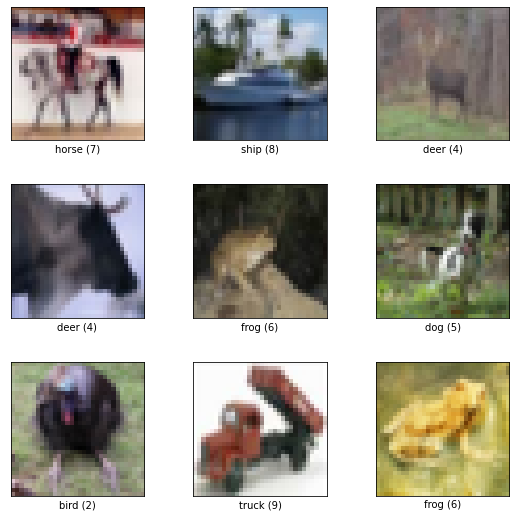

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

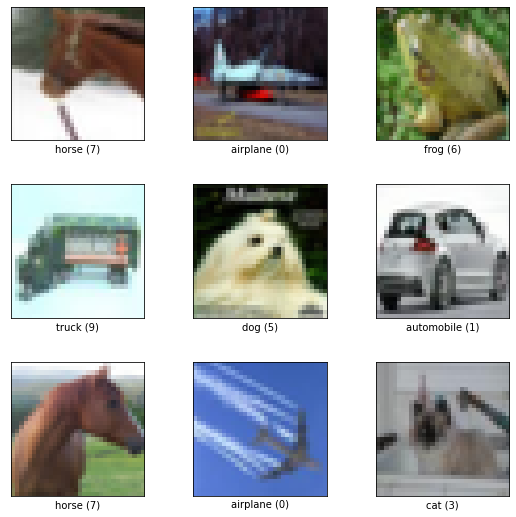

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

# 2-4. Ablation Study 실습 (2) 블록 구성하기

모델을 프로그램으로 구현하는 과정에서 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현할 때 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 작업이 필요하다.

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 __블록(block)__이라고 부른다. __레이어(layer)__는 기본적으로 텐서플로우, 케라스, 파이토치 등에서 기본적으로 제공하는 단위이다. 우리는 여기서 한 단계 위인 블록을 단위로 모델을 만들 수 있어야 한다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/resnet.max-800x600.png)

프로젝트로 구현할 __ResNet__을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크가 있다. 각 네트워크를 하나씩 구현하는 방법도 있지만, 반복 작업이고 변경사항이 생기면 모두 고쳐야하는 불편함이 생긴다. 그래서 실습에 ResNet의 기본 구조인 블록을 먼저 구현해보자.   

__구현하기 비교적 쉬운 VGG로 만들어보자__

### VGG 기본 블록 만들기

![](https://d3s0tskafalll9.cloudfront.net/media/images/vgg_structure.max-800x600.png)

VGG도 여러가지 버전이 있다. 이들 중 VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다는 가정하고 블록을 구현해보자.

블록 구현하기 위해 모델 구조의 특징을 짚어보자.   
VGG의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어져있다. CNN은 모두 커널(필터) 크기가 3x3인 대표적인 특징을 갖고 있다.   
그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다. 블록에 따라 CNN 레이어의 개수 또한 달라진다.   
블록의 마지막에 항상 Max Pooling 레이어가 붙는다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야한다.

`block_num`은 레이어의 이름을 붙여주기 위해 추가되었고 `input_shape`는 summary를 출력하기 위해 넣었다.

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

위에서 만든 VGG 블록을 추가하는 함수를 이용해서 `input_layer`에 추가해보자. 입력 레이어는 아까 데이터셋에서 확인한 32, 32 픽셀의 크기를 가지고 채널도 3을 가지므로 `(32, 32, 3)`이 된다. 이 입력 레이어를 인자로 받아 `build_vgg_block()`은 블록의 레이어를 build하고 출력값을 얻을 수 있다.   
케라스의 `Model` 클래스에서 `input`과 `output`을 정의해주면 간단히 블록의 모델을 확인해볼 수 있다.   
- [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

# 2-5. Ablation Study 실습 (3) VGG Complete Model

기본적인 블록을 만들 수 있는 함수를 구현했으니 이를 합쳐 전체 모델을 만들 수 있는 함수를 만들어보자.

### 1) VGG-16

먼저 작은 네트워크 VGG-16을 먼저 만들어보자. 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라진다. 이는 VGG-16, VGG-19에 따라 같이 변화되므로 함수에 전달되어야 한다. 여기서는 블록 별 CNN 수와 채널을 리스트로 전달했다.

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

### 2) VGG-19
구성(configuration)을 바꿔서 VGG-19을 만들 수 있다.

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

# 2-6. Ablation Study 실습 (4) VGG-16 cs VGG-19

준비한 데이터셋과 모델 성능 비교를 위해 모델을 훈련하고 평가해보자.   

우선 CIFAR-10 데이터셋을 불러오자.

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

VGG-16 모델을 만들고 훈련시키자.   

❗️ 이 훈련은 40 Epoch 정도 수행하는 것을 권장하지만, 15 Epoch 정도로 어느정도 근접하는 성능을 얻을 수 있다.

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

VGG-19 모델을 만들고 훈련시키자.   

❗️ 파라미터가 더 많은 VGG-19는 16보다 1/4 정도 훈련 시간이 더 걸린다.

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

이 둘의 학습 결과를 그래프를 통해 알아보자. 먼저 training loss의 경과를 비교해보고, validation accuracy를 비교해보자.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 2-7. 프로젝트: ResNet Ablation Study

### 0) 라이브러리 버전 확인하기


In [ ]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

### 1) ResNet 기본 블록 구성하기

실전으로 돌아가서 ResNet-34, ResNet-50 네트워크를 직접 만들어보자. 우선 ResNet-34, 50 에서 사용되는 블록의 공통점과 차이점을 찾아보자.

- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)
- [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

답을 찾았으면 ResNet의 기본 블록, 또는 Residual block이 어떻게 구성되어야할지 감을 잡을 수 있을것이다.   

VGG에서 블록을 생성하는 함수를 토대로 ResNet의 블록을 생성하는 함수를 만들어보자.

__논문을 통해서 구현 방법에 대한 정보를 얻길 권한다.__

### 2) ResNet-34, ResNet-50 Complete Model

ResNet 모델 구현 시 Sequential API나 Subclass API를 사용하면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 `model.summary()` 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있다. 모델 구성만을 위해서 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시처럼 Functional API를 구성하는 방식을 사용하자.